In [24]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

In [69]:
using Base.Threads
using BenchmarkTools
using Random, Distributions

In [26]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

## Let's start with defined relationships

## Basic no space solve

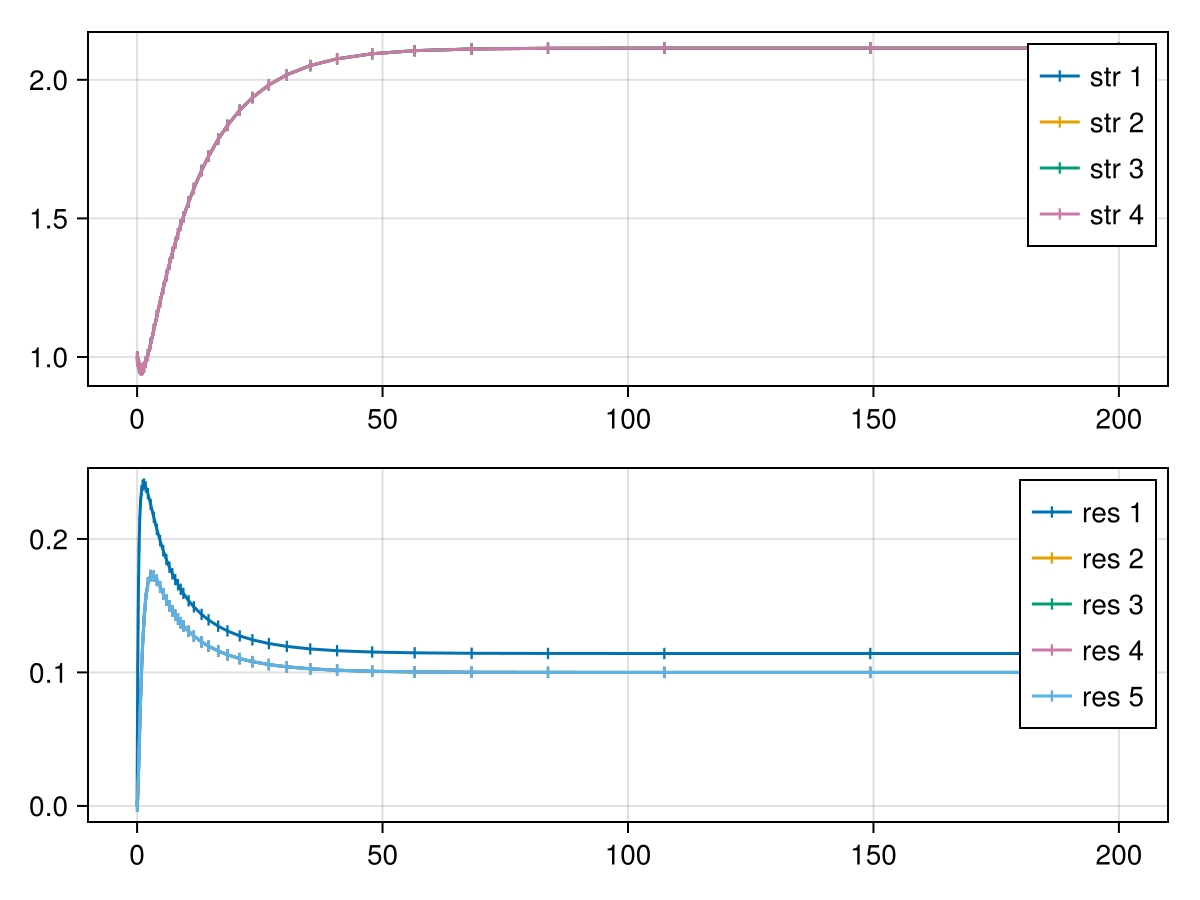

9-element Vector{Float64}:
 2.1143577795807427
 2.1143577795807427
 2.1143577795807427
 2.1143577795807427
 0.11418873751143141
 0.10000002904069157
 0.10000002904069157
 0.10000002904069157
 0.10000002904069157

In [41]:
S = 4
M = 5

D = fill(0., S, M, M)
D[1,2,1] = 1.
D[2,3,1] = 1.
D[3,4,1] = 1.
D[4,5,1] = 1.

K = fill(0., M)
K[1] = 1.


l = fill(0., S, M)
l[1,1] = 1.
l[2,1] = 1.
l[3,1] = 1.
l[4,1] = 1.

c = fill(0., S, M)
for i in 1:S
    for j in 1:M
        if i == j
            c[i,j] = 1.
        elseif j == 1
            c[i,j] = 1.
        end
    end
end
c[1,5] = 1.

r=fill(0.3,M)
m=fill(0.1,S)

params = make_sammicrmparams(S, M;
    D=SArray{Tuple{S,M,M}}(D),
    K=K,
    r=r,
    l=l,
    c=c,
    m=m
)


u = fill(0., S+M)
u[1:S] .= 1.

u0 = make_u0_smart(params;
    u0=u,
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p)

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

#### Steady state solving

In [42]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[2.1143402595254153, 2.1143402595254153, 2.1143402595254153, 2.1143402595254153, 0.11418966061391782, 0.10000076127446407, 0.10000076127446407, 0.10000076127446407, 0.10000076127446407]

## Spatial stuff

In [49]:
Ds = fill(0., S+M)
for i in 1:S
    Ds[i] = 1.0e-7
end

for i in S+1:S+M
    Ds[i] = rand()*1.0e2
end

Ds = SArray{Tuple{S+M}}(Ds)

usol = s.u[end]
nothing

In [50]:
da_get_diff_lengthscales_simple(params, Ds, usol)

(0.00010000001452034473, Inf)

### Linear stability analysis

In [51]:
ks = LinRange(0., 10., 10000)
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, params, 0))

[6.140241212396335e-8, 6.140241212396335e-8, 6.140241212396335e-8, 6.140241212396335e-8, -3.244622903686434e-9, -2.5748954912696576e-9, -2.5748954912696576e-9, -2.5748954912696576e-9, -2.5748954912696576e-9]

mrl = 0.00015769438336146537


┌ Info: Unstable, mrl is 0.000157694
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/plotting.jl:92


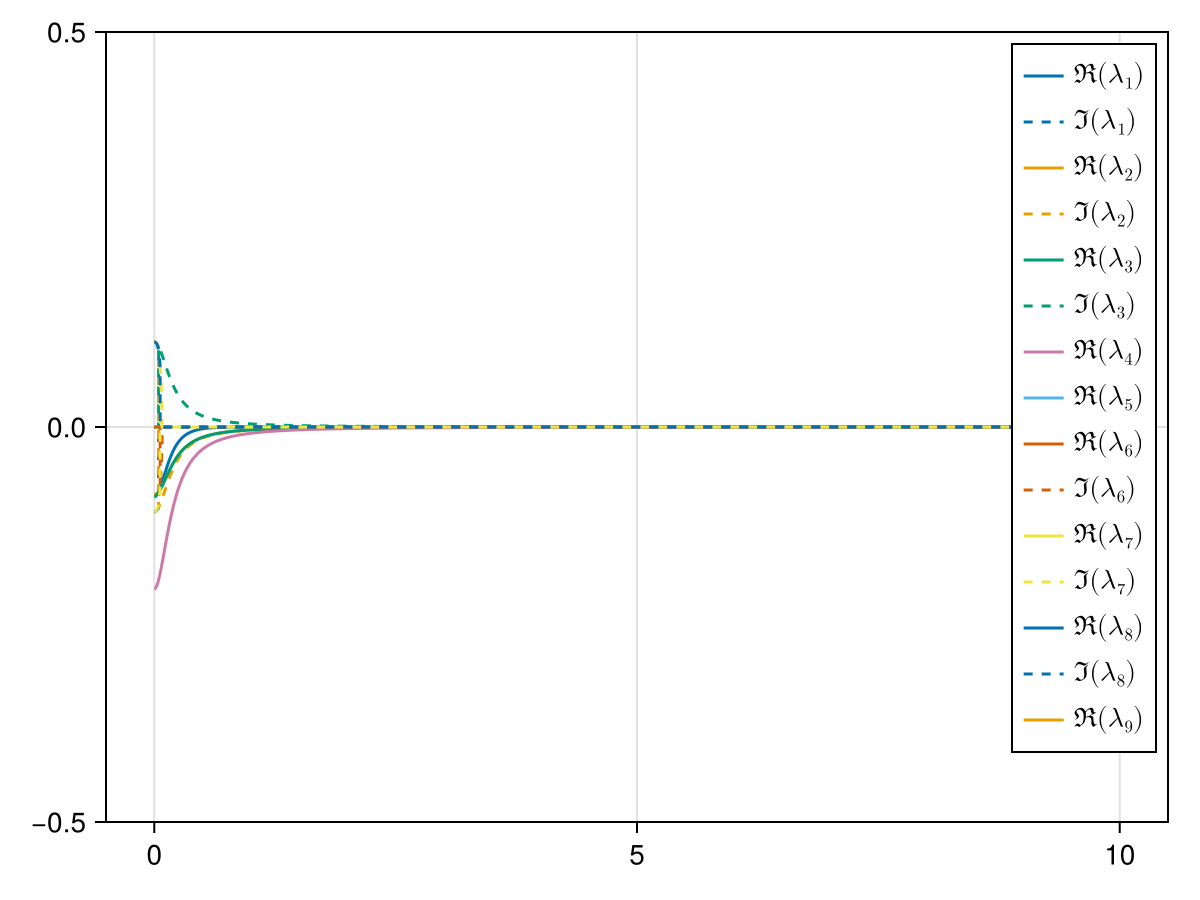

In [52]:
lambda_func = linstab_make_k_func(params, Ds, usol)
full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)
@show mrl

faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-0.5, 0.5))
# xlims!(faa.axis, (0., 2.))
faa

In [53]:
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
@show kmax
flmax = full_linstab_func(kmax)
flmax.vectors[:,1]

kmax = 1.236123612361236


9-element Vector{ComplexF64}:
    -0.5045302854722685 + 0.0im
    -0.4990570406083143 + 0.0im
    -0.5033405169607906 + 0.0im
   -0.49298747128921305 + 0.0im
   0.001712549784848466 + 0.0im
  -3.725020243702736e-5 + 0.0im
 -3.7569926133417466e-5 + 0.0im
 -3.6797162671477065e-5 + 0.0im
  -3.765873184811769e-5 + 0.0im

### Spatial stuff - 1D!

In [54]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.01, 0.01)

space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 10000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((9, 4000), 1, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [58]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

  5.405408 seconds (457.94 k allocations: 1.531 GiB, 70.50% gc time)
Success
nf is 119
solution has 39 saved states
max resid is 1.65942e-06


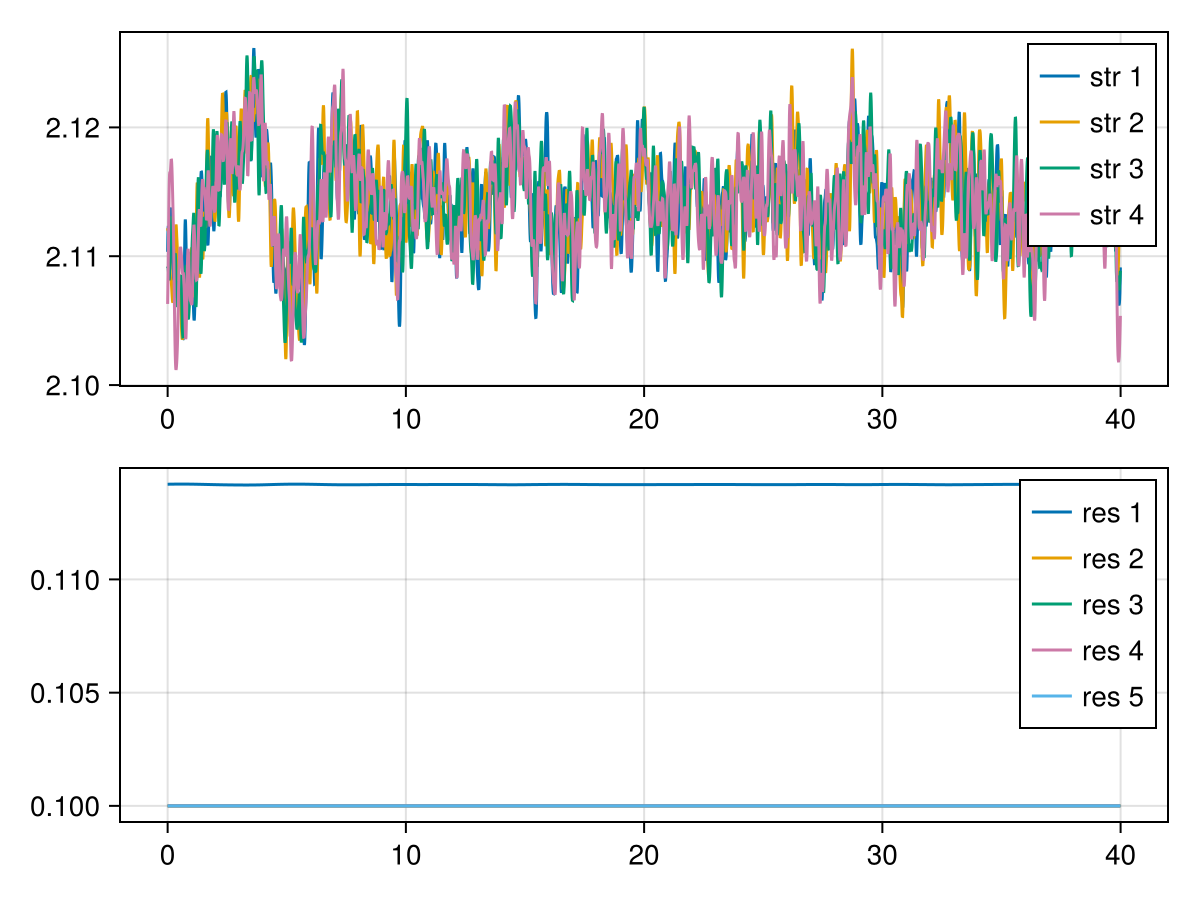

In [60]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
# display(GLMakie.Screen(), faa.figure)
faa

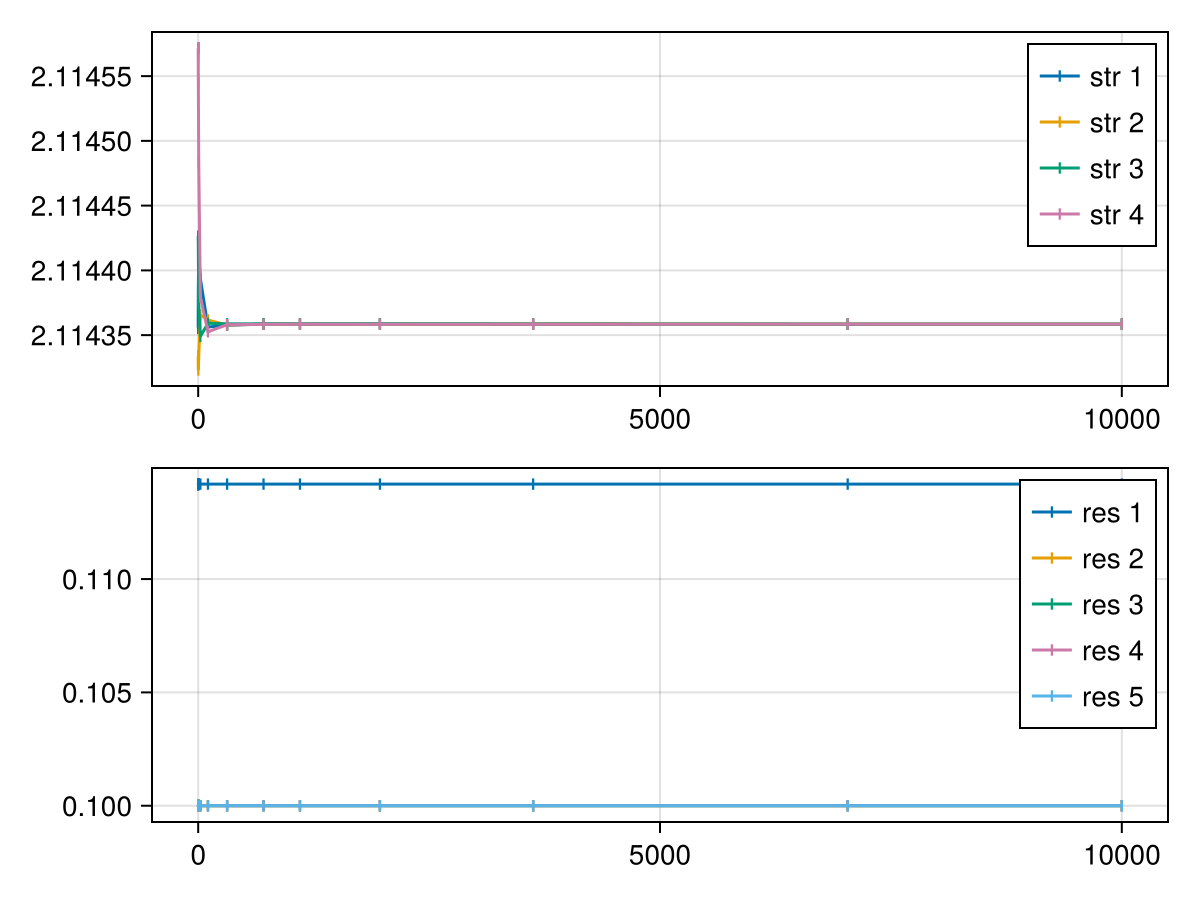

In [57]:
f = plot_smmicrm_sol_avgs(sps)
# display(GLMakie.Screen(), f)
f

#### Steady state solver

ReturnCode.Success = 1

424

  8.460652 seconds (10.98 M allocations: 2.921 GiB, 43.55% gc time, 28.55% compilation time)


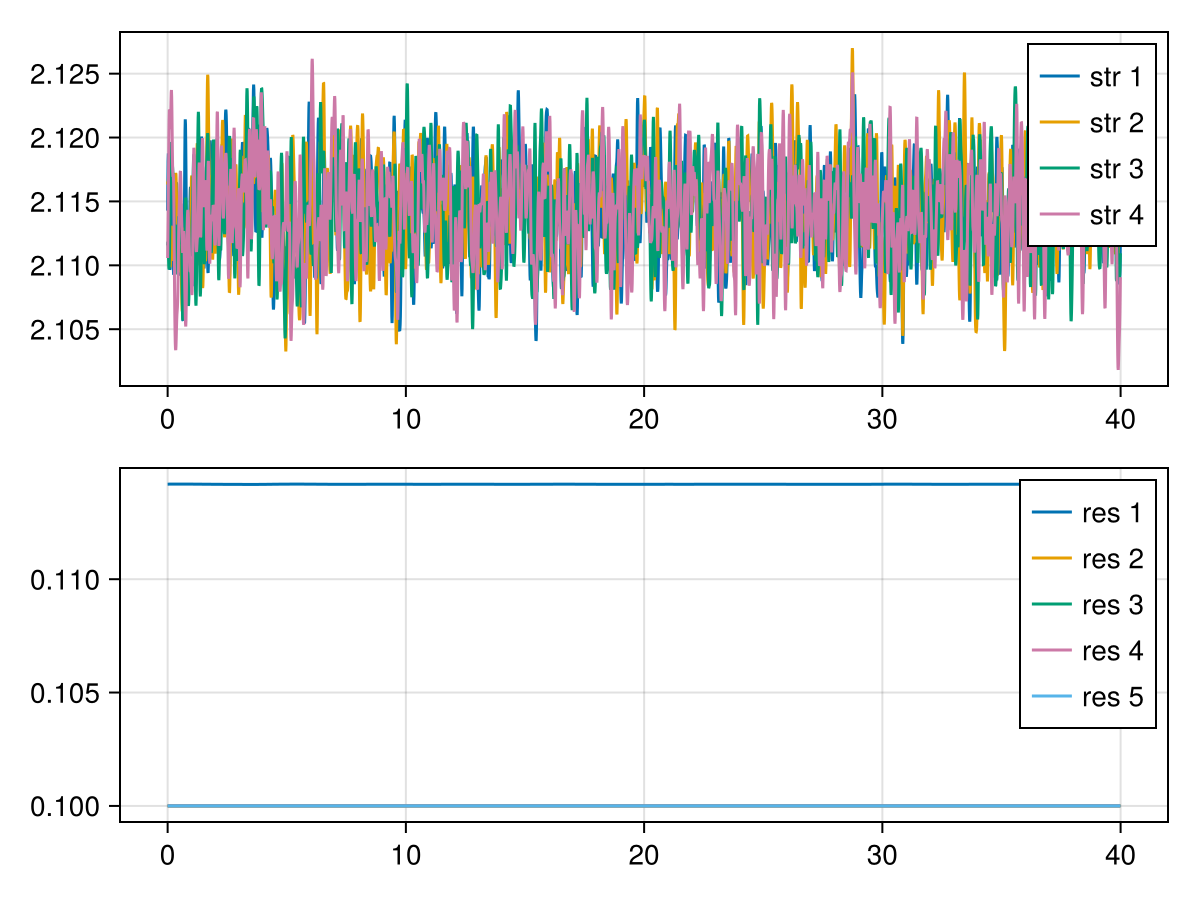

In [61]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

### Spatial stuff - 2D!

In [62]:
ssize = (70, 70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.01, 0.01)

space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 100000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((9, 70, 70), 1, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [63]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 53.517871 seconds (14.62 M allocations: 22.454 GiB, 8.74% gc time, 11.93% compilation time)
Success
nf is 1193
solution has 160 saved states
max resid is 0.0192734


┌ Warning: reaching negative values, minimum is -1.29226e-05
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


In [ ]:
plot_2dsmmicrm_sol_snap_heatmap(sps, -1)
#display(GLMakie.Screen(), plot_2dsmmicrm_sol_interactive_heatmap(sps))

GLMakie.Screen(...)

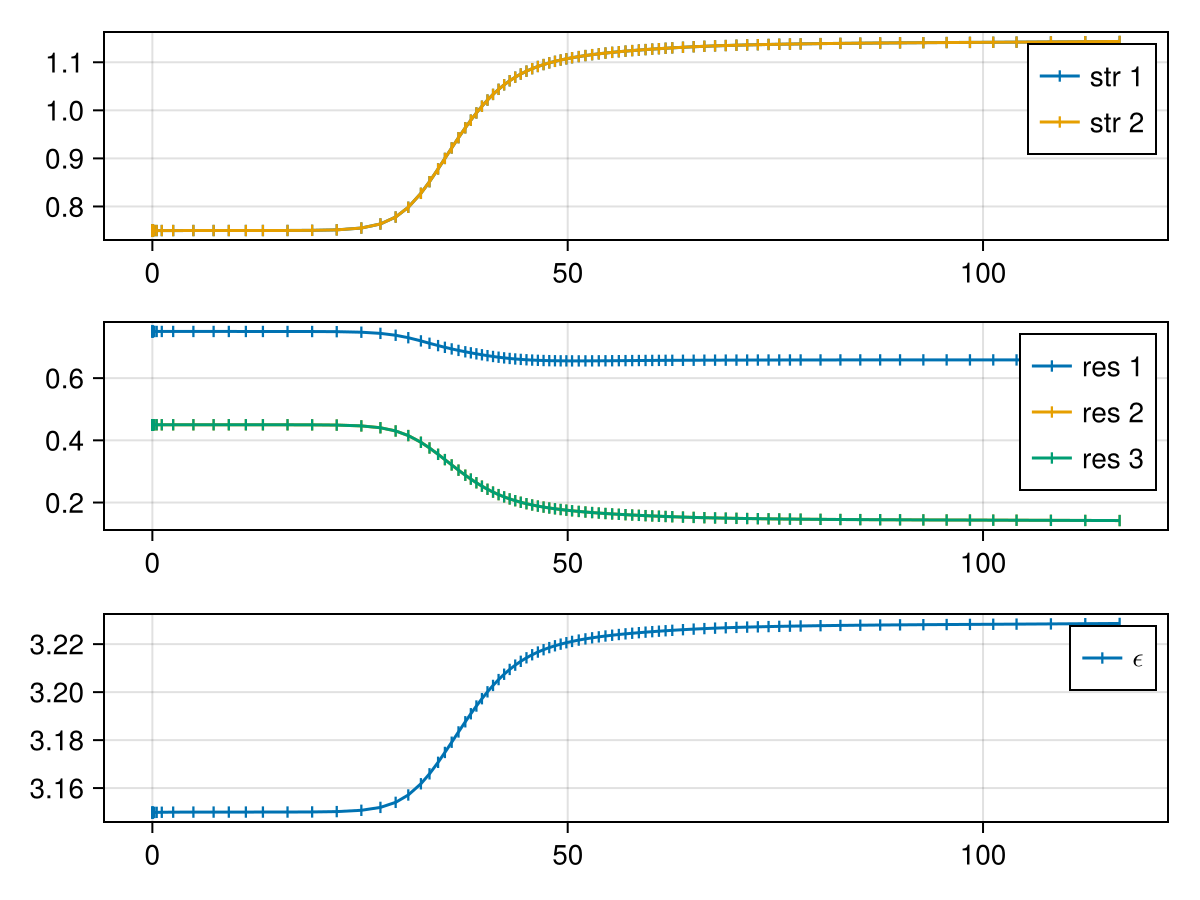

In [63]:
plot_smmicrm_sol_avgs(sps, 1:100; plote=true)

## Time to try and sample all interaction networks

In [66]:
# doesn't change
S = 4
M = 5

K = fill(0., M)
K[1] = 1.


l = fill(0., S, M)
l[1,1] = 1.
l[2,1] = 1.
l[3,1] = 1.
l[4,1] = 1.


r=fill(0.3,M)
m=fill(0.1,S)




4-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1

In [70]:
# time to sample

D = fill(0., S, M, M)

for i in 1:S
    for j in 1:M
        row = rand(Dirichlet(fill(0.1, M)))
        D[i,:,j] = row
    end
end

c = fill(0., S, M)
for i in 1:S
    c[i,1] = 1.
    rest = rand(Dirichlet(fill(0.1, M-1)))
    c[i,2:M] = rest
end

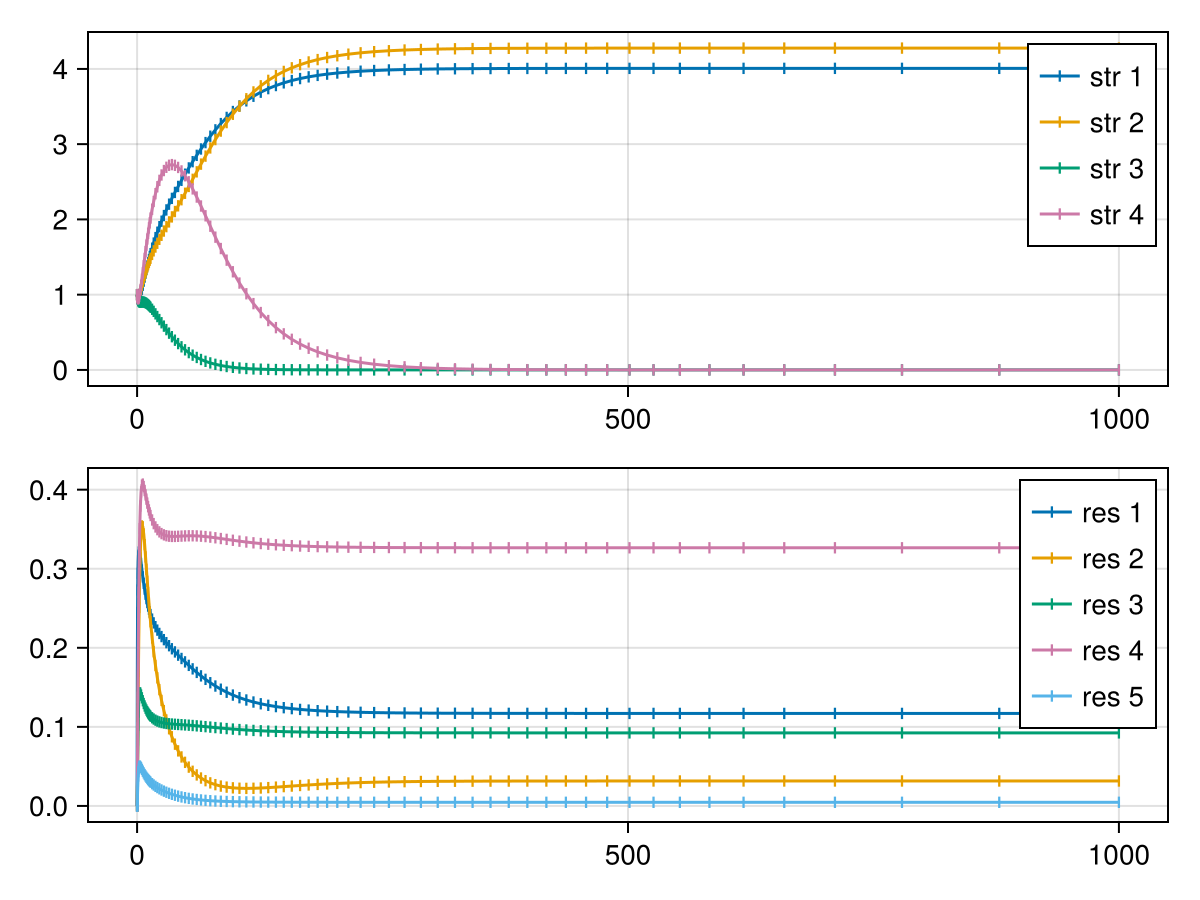

┌ Info: strain 1 leaks less than it energetically can through consuming 1
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:116
┌ Error: strain 1 leaks more than it energetically can through consuming 2
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:113
┌ Error: strain 1 leaks more than it energetically can through consuming 5
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:113
┌ Error: strain 2 leaks more than it energetically can through consuming 1
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:113
┌ Error: strain 3 leaks more than it energetically can through consuming 2
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:113
┌ Error: strain 4 leaks mo

9-element Vector{Float64}:
  4.00749614335669
  4.276729557474326
 -3.119144362629546e-19
  1.0121455043019692e-10
  0.1169938241975428
  0.031524213155167784
  0.09237272513329346
  0.32647915517004816
  0.0045548486998572444

In [72]:
# start the actual simulation
params = make_sammicrmparams(S, M;
    D=SArray{Tuple{S,M,M}}(D),
    K=K,
    r=r,
    l=l,
    c=c,
    m=m
)


u = fill(0., S+M)
u[1:S] .= 1.

u0 = make_u0_smart(params;
    u0=u,
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 1000)
s = solve(p)

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

## Let's do some random sampling and plotting

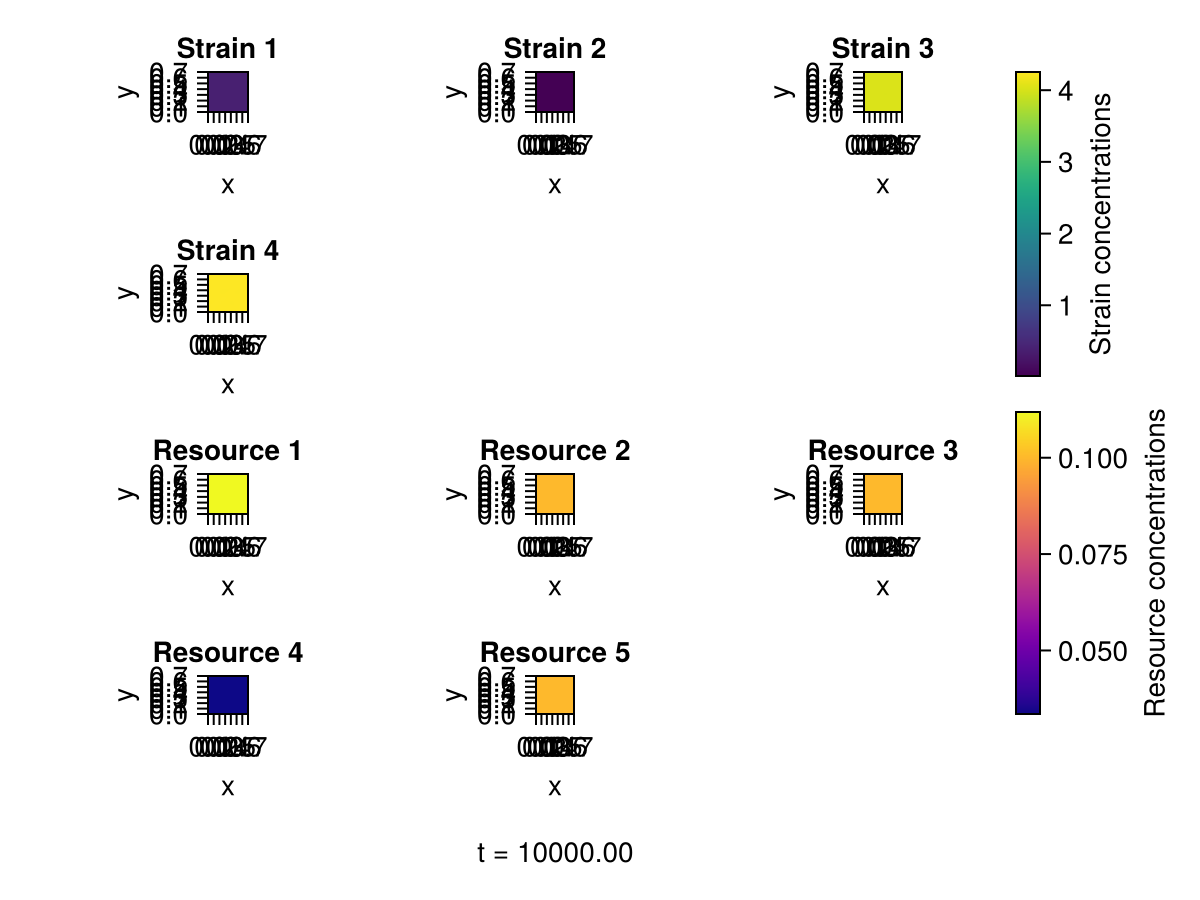

 45.360830 seconds (657.31 k allocations: 13.116 GiB, 11.74% gc time)
 53.527406 seconds (661.07 k allocations: 11.931 GiB, 36.29% gc time)
 36.320154 seconds (661.07 k allocations: 15.098 GiB, 4.06% gc time)
 34.395886 seconds (660.63 k allocations: 14.471 GiB, 4.09% gc time)
 46.901340 seconds (665.61 k allocations: 16.633 GiB, 15.61% gc time)


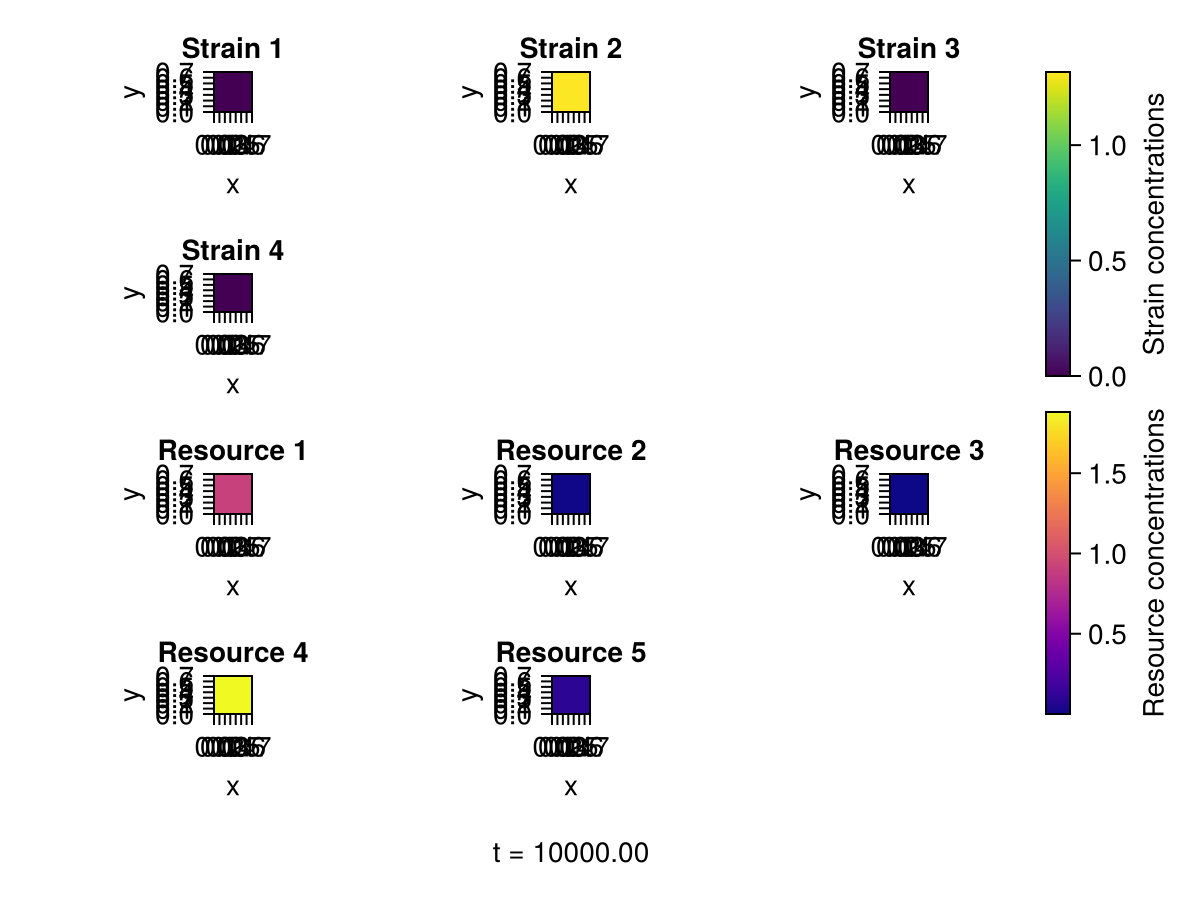

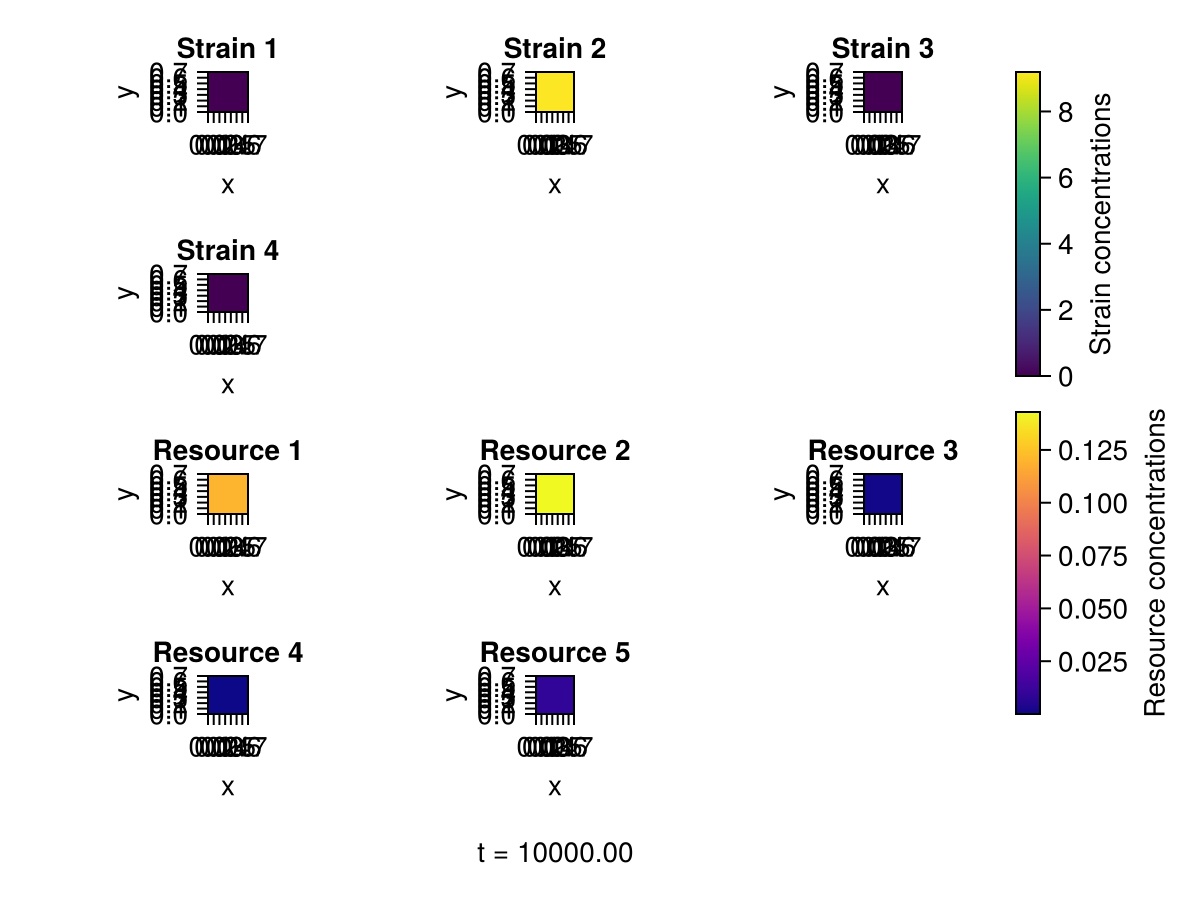

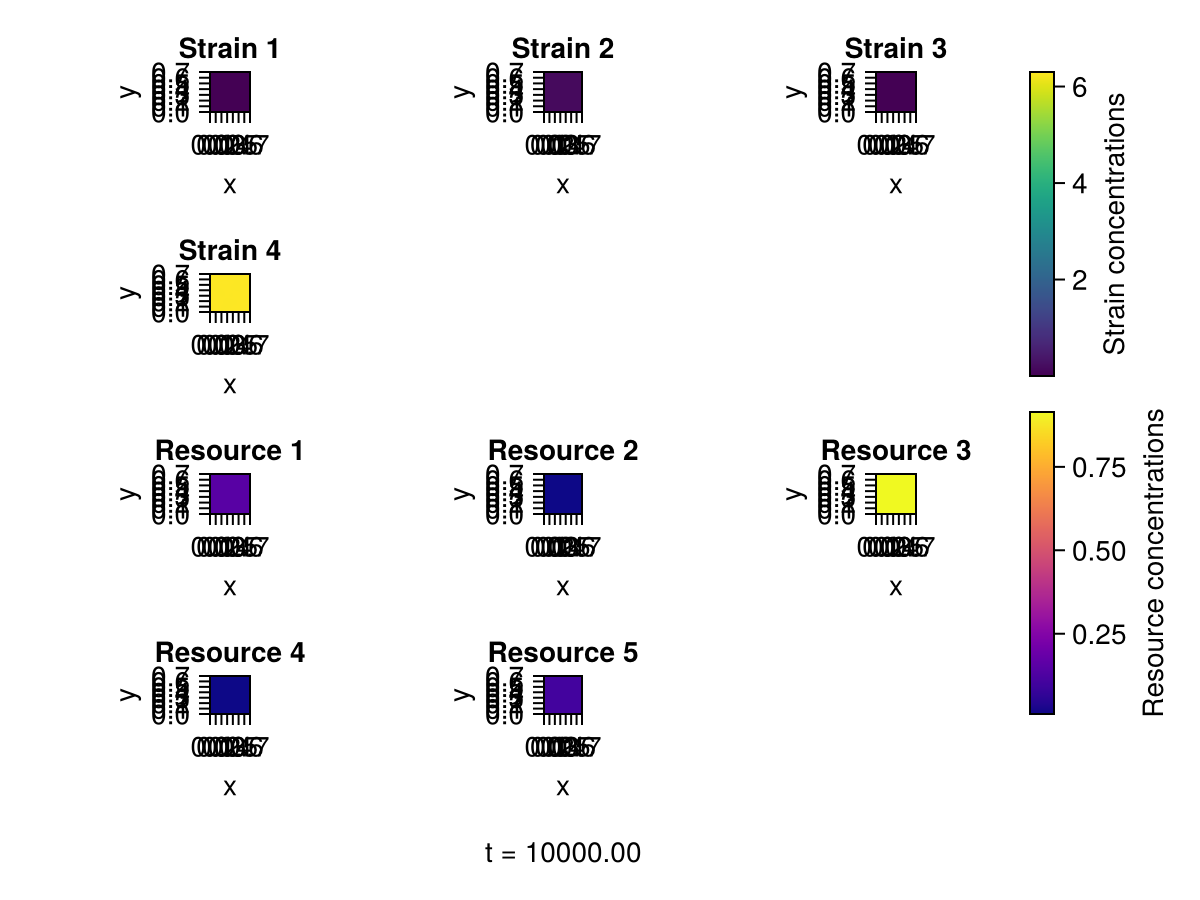

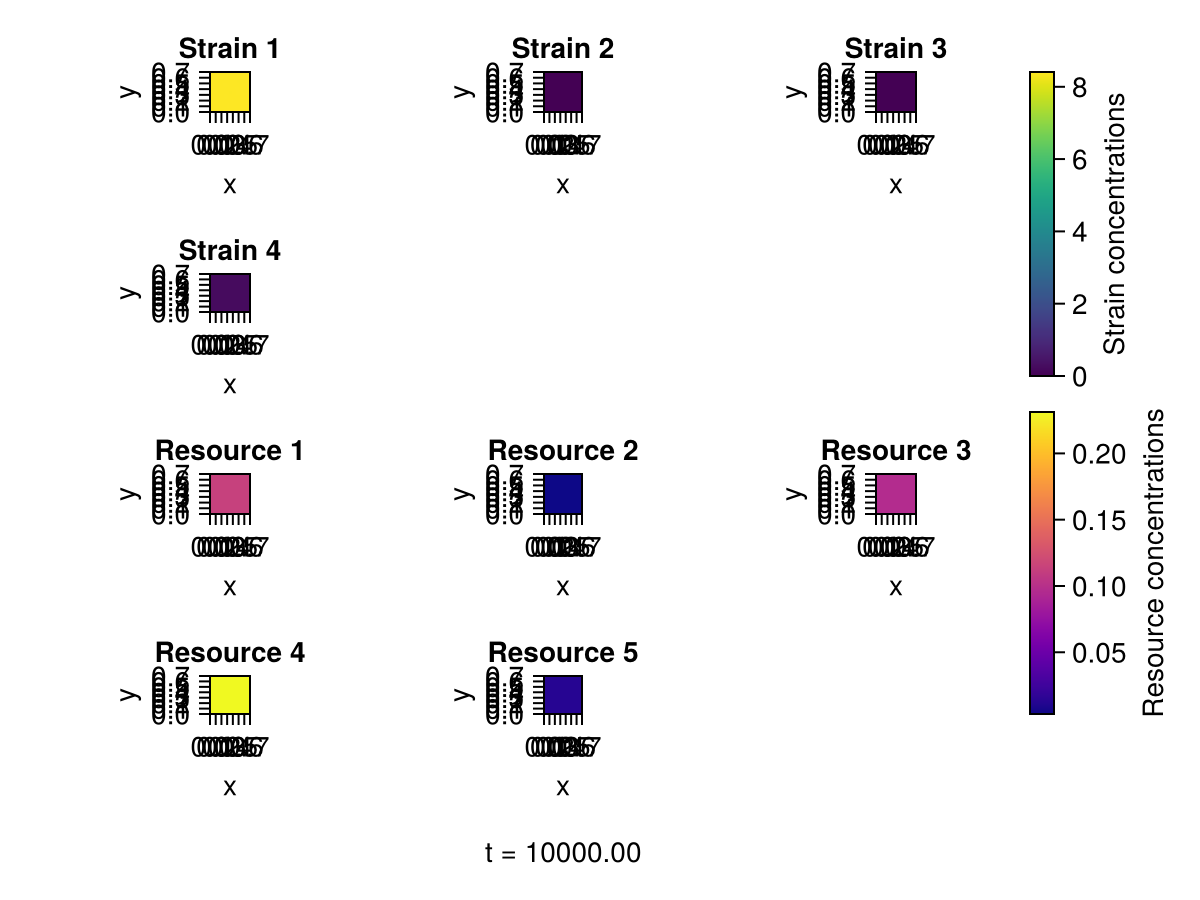

In [77]:
nrep = 5

# doesn't change
S = 4
M = 5

K = fill(0., M)
K[1] = 1.


l = fill(0., S, M)
l[1,1] = 1.
l[2,1] = 1.
l[3,1] = 1.
l[4,1] = 1.


r=fill(0.3,M)
m=fill(0.1,S)

for i in 1:nrep
    D = fill(0., S, M, M)

    for i in 1:S
        for j in 1:M
            row = rand(Dirichlet(fill(0.1, M)))
            D[i,:,j] = row
        end
    end

    c = fill(0., S, M)
    for i in 1:S
        c[i,1] = 1.
        rest = rand(Dirichlet(fill(0.1, M-1)))
        c[i,2:M] = rest
    end

    # start the actual simulation
    params = make_sammicrmparams(S, M;
        D=SArray{Tuple{S,M,M}}(D),
        K=K,
        r=r,
        l=l,
        c=c,
        m=m
    )

    u = fill(0., S+M)
    u[1:S] .= 1.

    u0 = make_u0_smart(params;
        u0=u,
        u0rand=0.
    )

    p = make_mmicrm_problem(params, u0, 1000)
    
    sssol = solve(SteadyStateProblem(p), DynamicSS())


    # now in space
    ssize = (70, 70)
    su0 = expand_u0_to_size(ssize, u0)
    psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.01, 0.01)

    space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
    usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

    sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
    sp = make_smmicrm_problem(sparams, psu0, 10000)

    @time sps = solve(sp, QNDF(); maxiters=1000)
    #faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
    faa = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)
    
    display(faa)
end

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()